# **XLM-ROBERTA-BASE PHASE 2**

This phase uses the `Sentiment-analysis-for-menttal-health.csv` dataset

**Source:** [sentiment-analysis-for-mental-health](https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health) 

---

## **Setup & Imports**

In [2]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers.trainer_utils import get_last_checkpoint
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils import resample
from torch.nn import CrossEntropyLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from tqdm import tqdm
from typing import List, Union, Dict
from collections import Counter
import langid
import pycountry
from wordcloud import WordCloud

---
## **Configurations**

In [7]:
DATA_PATH = "../../../data/nlp/combined_augmented_datasets/combined_cleaned_dataset_v3.csv"
MODEL_NAME = "xlm-roberta-base"

MODEL_PATH_FINETUNE = "../../../models/nlp/xlm-roberta/phase-2/sentiment_finetune"
MODEL_PATH_MODEL = "../../../models/nlp/xlm-roberta/phase-2/sentiment_model"
MODEL_PATH_MODEL_1 = "../../../models/nlp/xlm-roberta/phase-3/sentiment_model"

---
## **Load Data**

In [8]:
# Load two datasets
dataset = load_dataset("csv", data_files=DATA_PATH)

# Define functions to rename datasets
def rename_data_columns(data: Dataset, column_names_to_change: List[str], new_column_names: List[str]) -> Dataset:
    if len(column_names_to_change) != len(new_column_names):
        raise ValueError("Both lists must have the same length.")
    
    dataset = data
    for old_name, new_name in zip(column_names_to_change, new_column_names):
        dataset = dataset.rename_column(old_name, new_name)

    print(dataset)
    
    return dataset

# Rename
print("\nDataset: Sentiment analysis for mental health")

# dataset = rename_data_columns(
#     data=dataset,
#     column_names_to_change=['status', 'statement'],
#     new_column_names=['labels', 'text']
#   )



Dataset: Sentiment analysis for mental health


---
## **Data Pre-Processing & Visualization**

### **1. Check Unique Labels**

labels
Normal                  15728
Depression              15390
Suicidal                10886
Anxiety                  7347
Stress                   6005
Bipolar                  2225
Personality disorder      715
Name: count, dtype: int64


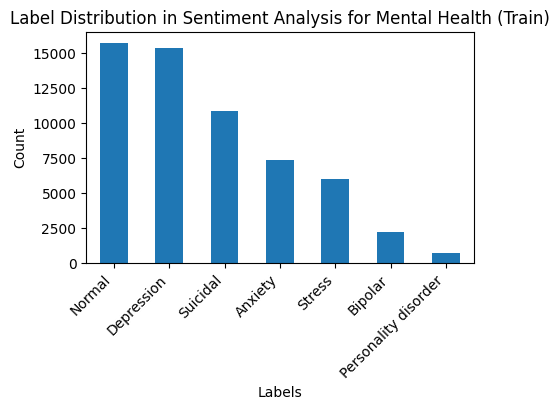

In [9]:
def label_visualization():
  # Convert data to pandas dataframe for visualization
  df = dataset["train"].to_pandas()

  # Count label frequencies
  label_df_counts = df["labels"].value_counts()
  print(label_df_counts)

  # Plot distribution for df_dataset_1
  plt.figure(figsize=(5, 3))
  label_df_counts.plot(kind="bar")
  plt.xticks(rotation=45, ha="right")
  plt.title("Label Distribution in Sentiment Analysis for Mental Health (Train)")
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.show()

label_visualization()

### **2. Remove Special Characters**

In [10]:
def clean_text(example):
    text = example.get("text", "")

    if text is None or not isinstance(text, str) or text.strip() == "":
        return {"text": ""}   # keep it empty; will be dropped later

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove newlines and other non-word characters except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return {"text": text}

dataset = dataset.map(clean_text)

dataset["train"].to_pandas().head()

,text,labels
0,oh my gosh,Anxiety
1,trouble sleeping confused mind restless heart ...,Anxiety
2,all wrong back off dear forward doubt stay in ...,Anxiety
3,ive shifted my focus to something else but im ...,Anxiety
4,im restless and restless its been a month now ...,Anxiety


### **3. Check For Rows That Has Null or Blank Values**

In [11]:
def check_for_null_blank(dataset, dataset_name="Dataset"):
    import pandas as pd

    # If it's a DatasetDict, loop over splits
    if hasattr(dataset, "keys"):  # DatasetDict
        for split in dataset.keys():
            print(f"Checking split: {split} in {dataset_name}\n")
            df = dataset[split].to_pandas()
            
            # Nulls
            print("Nulls in each column:")
            print(df[["text", "labels"]].isnull().sum())
            print("\n")
            
            # Rows with nulls
            print("Rows where text or labels are null/blank:")
            print(df[df["text"].isnull() | df["labels"].isnull()])
            print("\n")
            
            # Blank strings
            print("Check for blank and empty string values:")
            print("Blank texts:", (df["text"].str.strip() == "").sum())
            print("Blank labels:", (df["labels"].astype(str).str.strip() == "").sum())
            print("\n")
    else:  # Single Dataset
        df = dataset.to_pandas()
        print(f"Checking {dataset_name}\n")
        print("Nulls in each column:")
        print(df[["text", "labels"]].isnull().sum())
        print("\n")
        print("Rows where text or labels are null/blank:")
        print(df[df["text"].isnull() | df["labels"].isnull()])
        print("\n")
        print("Check for blank and empty string values:")
        print("Blank texts:", (df["text"].str.strip() == "").sum())
        print("Blank labels:", (df["labels"].astype(str).str.strip() == "").sum())
        print("\n")

check_for_null_blank(dataset=dataset, dataset_name="tweet-emotions")

Checking split: train in tweet-emotions

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [text, labels]
Index: []


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0




### **4. Drop Rows That Has Null/Blank/Empty String Values**

In [13]:
# Drop rows where statement or status is null
def drop_nulls_from_dataset(dataset, columns=["text", "labels"]):
    """
    Drops null and blank values from a Dataset or DatasetDict.
    Works for both cases.
    """
    if isinstance(dataset, DatasetDict):  # Case 1: DatasetDict with train/test
        cleaned_splits = {}
        for split_name, ds_split in dataset.items():
            df = ds_split.to_pandas()
            df = df.dropna(subset=columns)
            if "text" in columns:
                df = df[df["text"].str.strip() != ""]
            cleaned_splits[split_name] = Dataset.from_pandas(df)
            print(f"✅ Cleaned {split_name}: {len(ds_split)} → {len(df)} rows")
        return DatasetDict(cleaned_splits)

    elif isinstance(dataset, Dataset):  # Case 2: Single Dataset
        df = dataset.to_pandas()
        df = df.dropna(subset=columns)
        if "text" in columns:
            df = df[df["text"].str.strip() != ""]
        cleaned_dataset = Dataset.from_pandas(df)
        print(f"✅ Cleaned dataset: {len(dataset)} → {len(df)} rows")
        return cleaned_dataset

    else:
        raise TypeError("Expected Dataset or DatasetDict")

dataset = drop_nulls_from_dataset(dataset=dataset)

# Check counts again
check_for_null_blank(dataset);

✅ Cleaned train: 58296 → 58296 rows
Checking split: train in Dataset

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [text, labels]
Index: []


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0




### **5. Feature Engineering**

Filter:   0%|          | 0/58296 [00:00<?, ? examples/s]


Final dataset size: 1
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 55356
    })
})
labels
Normal        15728
Depression    15390
Suicidal      10886
Anxiety        7347
Stress         6005
Name: count, dtype: int64


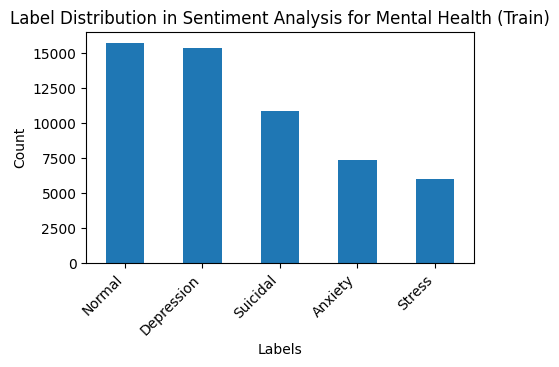

In [14]:
# Remove unwanted column/feature
# Based on the graphs above i don't want "Bipolar", "Personality Disorder"
unwanted_labels_1 = ["Bipolar", "Personality disorder"]
dataset["train"] = dataset["train"].filter(
    lambda example: example["labels"] not in unwanted_labels_1
)

print("\nFinal dataset size:", len(dataset))
print(dataset)

label_visualization()

### **6. Check for duplicate rows**


In [15]:
def check_for_duplicates(dataset, dataset_name="Dataset", text_column="text", label_column="labels"):
    """
    Checks for duplicate rows in a Hugging Face Dataset or DatasetDict.
    Detects duplicates based on text only, or text+label if specified.
    """

    if isinstance(dataset, DatasetDict):  # Case 1: DatasetDict
        for split_name, ds_split in dataset.items():
            df = ds_split.to_pandas()
            print(f"🔍 Checking duplicates in split: {split_name} ({dataset_name})\n")
            
            # Duplicates by text only
            dup_text = df[df.duplicated(subset=[text_column], keep=False)]
            print(f"Duplicates by `{text_column}` only: {len(dup_text)} rows")
            if not dup_text.empty:
                print(dup_text.head())
            print("\n")
            
            # Duplicates by text + label (exact row duplicates)
            dup_both = df[df.duplicated(subset=[text_column, label_column], keep=False)]
            print(f"Duplicates by `{text_column}` + `{label_column}`: {len(dup_both)} rows")
            if not dup_both.empty:
                print(dup_both.head())
            print("\n")

    elif isinstance(dataset, Dataset):  # Case 2: Single Dataset
        df = dataset.to_pandas()
        print(f"🔍 Checking duplicates in {dataset_name}\n")
        
        # Duplicates by text only
        dup_text = df[df.duplicated(subset=[text_column], keep=False)]
        print(f"Duplicates by `{text_column}` only: {len(dup_text)} rows")
        if not dup_text.empty:
            print(dup_text.head())
        print("\n")
        
        # Duplicates by text + label (exact row duplicates)
        dup_both = df[df.duplicated(subset=[text_column, label_column], keep=False)]
        print(f"Duplicates by `{text_column}` + `{label_column}`: {len(dup_both)} rows")
        if not dup_both.empty:
            print(dup_both.head())
        print("\n")
    else:
        raise TypeError("Expected Dataset or DatasetDict")
    
check_for_duplicates(dataset, dataset_name="tweet-emotions")


🔍 Checking duplicates in split: train (tweet-emotions)

Duplicates by `text` only: 1061 rows
                                       text   labels
13                because this worry is you  Anxiety
17                restive restless restless  Anxiety
24  ive been so restless since this morning  Anxiety
25               it makes you feel restless  Anxiety
31                  terooosss nervous huuuu  Anxiety


Duplicates by `text` + `labels`: 1061 rows
                                       text   labels
13                because this worry is you  Anxiety
17                restive restless restless  Anxiety
24  ive been so restless since this morning  Anxiety
25               it makes you feel restless  Anxiety
31                  terooosss nervous huuuu  Anxiety




In [16]:
def drop_duplicates_from_dataset(dataset, text_column="text", by_text_only=True):
    """
    Drops duplicate rows from a Hugging Face Dataset or DatasetDict.

    Args:
        dataset: Dataset or DatasetDict
        text_column: column to check for duplicates
        by_text_only: 
            - True  = drop rows where the same text appears more than once (remove ALL copies)
            - False = drop rows where the same text+label pair appears more than once (remove ALL copies)
    
    Returns:
        Cleaned Dataset or DatasetDict
    """
    from datasets import Dataset, DatasetDict

    def _clean(df):
        # Decide grouping
        subset_cols = [text_column] if by_text_only else [text_column, "labels"]

        # Find duplicates → mark all occurrences
        dup_mask = df.duplicated(subset=subset_cols, keep=False)

        # Keep only unique rows
        df_cleaned = df[~dup_mask].reset_index(drop=True)

        removed = len(df) - len(df_cleaned)
        return df_cleaned, removed

    if isinstance(dataset, DatasetDict):  # Case 1: DatasetDict
        cleaned_splits = {}
        for split_name, ds_split in dataset.items():
            df = ds_split.to_pandas()
            df_cleaned, removed = _clean(df)
            print(f"✅ Cleaned {split_name}: {len(df)} → {len(df_cleaned)} rows (removed {removed})")
            cleaned_splits[split_name] = Dataset.from_pandas(df_cleaned, preserve_index=False)
        return DatasetDict(cleaned_splits)

    elif isinstance(dataset, Dataset):  # Case 2: Single Dataset
        df = dataset.to_pandas()
        df_cleaned, removed = _clean(df)
        print(f"✅ Cleaned dataset: {len(df)} → {len(df_cleaned)} rows (removed {removed})")
        return Dataset.from_pandas(df_cleaned, preserve_index=False)

    else:
        raise TypeError("Expected Dataset or DatasetDict")

# Remove ALL rows where text is duplicated (even with different labels)
dataset = drop_duplicates_from_dataset(dataset, by_text_only=True)

# Check again
check_for_duplicates(dataset)

✅ Cleaned train: 55356 → 54295 rows (removed 1061)
🔍 Checking duplicates in split: train (Dataset)

Duplicates by `text` only: 0 rows


Duplicates by `text` + `labels`: 0 rows




In [12]:
# # language distribution
# plt.bar(lang_counts.keys(), lang_counts.values())
# plt.title("Language distribution in sample")
# plt.xlabel("Language")
# plt.ylabel("Count")
# plt.show()

### **7. Create Word Cloud**

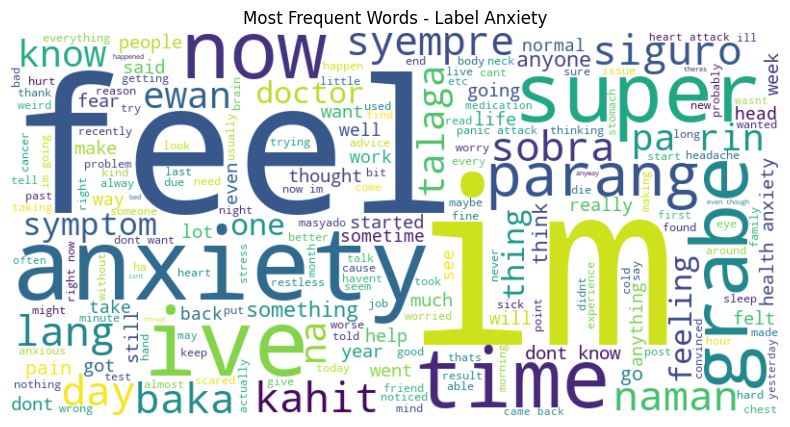

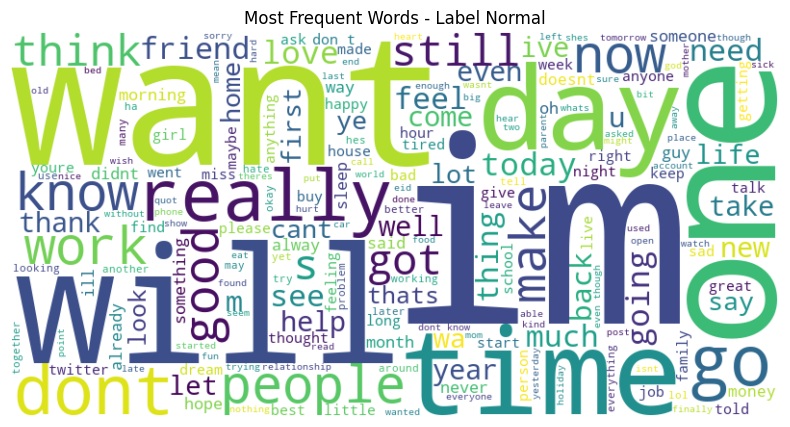

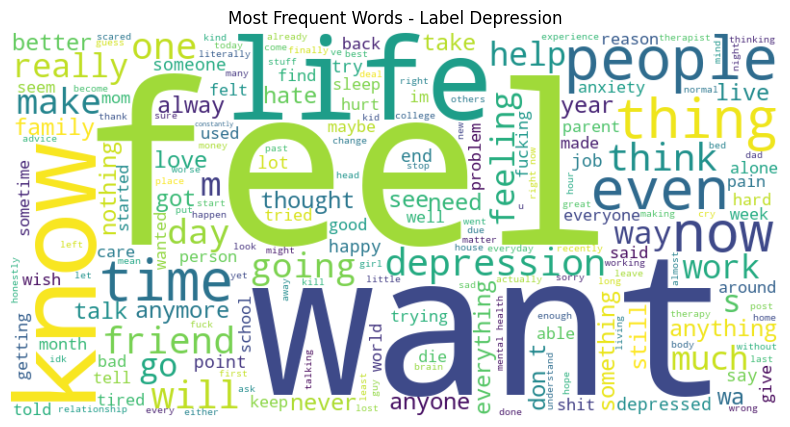

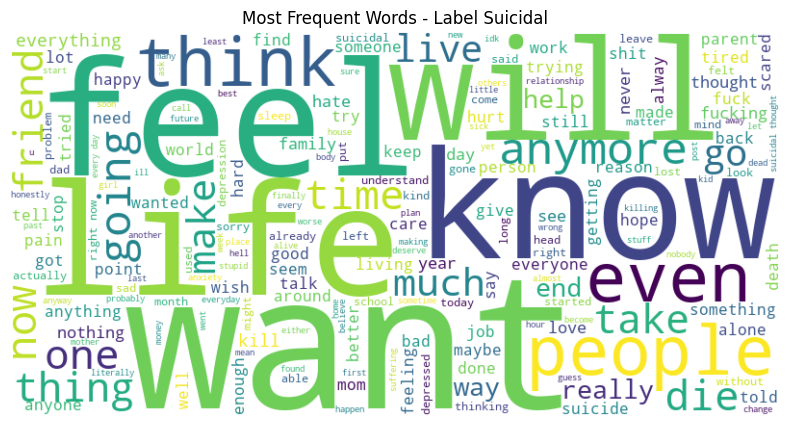

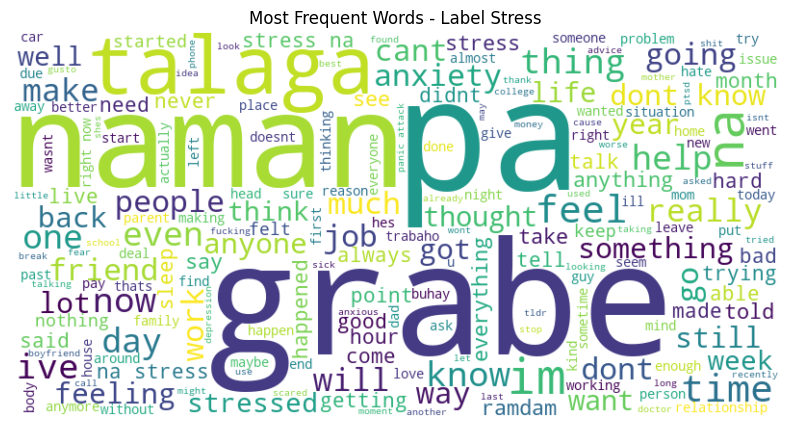

In [11]:
df_wordcloud = dataset['train'].to_pandas()

for label in df_wordcloud['labels'].unique():
    # combine all text for this label
    text = " ".join(df_wordcloud[df_wordcloud['labels'] == label]['text'].astype(str))
    
    # generate word cloud
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    # plot
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Most Frequent Words - Label {label}")
    plt.show()


### **8. Pre-process and Encode Label**

Map:   0%|          | 0/54295 [00:00<?, ? examples/s]

labels
1    15728
2    14809
3    10615
0     7180
4     5963
Name: count, dtype: int64


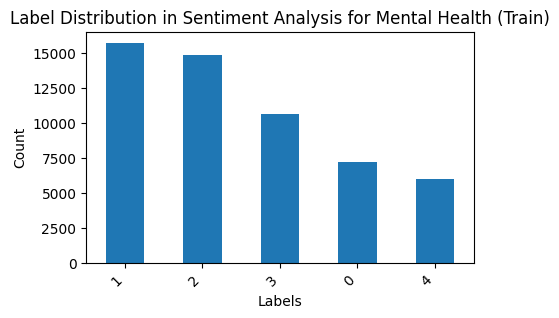

In [17]:
# Get unique labels
labels = dataset["train"].unique("labels")
label_to_id = {l: i for i, l in enumerate(labels)}
id_to_label = {i: l for l, i in label_to_id.items()}

def make_label_encoder(label_to_id: dict, column_name: str = "labels"):
    """Returns a function that encodes labels for the given column using label_to_id mapping."""
    def encode_labels(example):
        example[column_name] = label_to_id[example[column_name]]
        return example
    return encode_labels

encoder_for_data = make_label_encoder(label_to_id, column_name="labels")

dataset = dataset.map(encoder_for_data)

# Re check if changes were applied correctly
label_visualization()

### **9. Split dataset**

In [18]:
def split_dataset_to_train_valid_test(dataset: DatasetDict, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42) -> DatasetDict:
    """
    Splits a dataset into train, validation, and test sets.
    - First, takes a portion (test_size) from 'train' to make the test set.
    - Then, splits the remaining train into train/validation (val_size).
    """
    if "train" not in dataset:
        raise ValueError("DatasetDict must contain a 'train' split.")

    # Split into train + test
    data = dataset["train"].train_test_split(test_size=test_size, seed=seed)
    original_train = data["train"]
    original_test = data["test"]

    # Split original train further into train + validation
    train_valid_split = original_train.train_test_split(test_size=val_size, seed=seed)

    return DatasetDict({
        "train": train_valid_split["train"],
        "validation": train_valid_split["test"],
        "test": original_test
    })

dataset = split_dataset_to_train_valid_test(dataset)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 34748
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 8688
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 10859
    })
})


---
## **Model Training / Fine-tuning**

### **1. Define model training functions**

#### **a. load tokenizer + model**

In [20]:
def load_model_and_tokenizer(model_name: str, labels: list[str], id2label: dict[int, str], label2id: dict[str, int]):
    """
    Loads a tokenizer and model for sequence classification.

    Args:
        model_name (str): Hugging Face model name or path.
        labels (list[str]): List of labels for classification.
        id2label (dict[int, str]): Mapping from ID to label name.
        label2id (dict[str, int]): Mapping from label name to ID.

    Returns:
        tokenizer, model
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id
    )
    return tokenizer, model

def tokenize_dataset(dataset: Dataset, tokenizer: PreTrainedTokenizerBase, max_length: int = 256, num_proc: int = 4):
    return dataset.map(
        lambda examples: tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
        ),
        batched=True,
        num_proc=num_proc
    )


#### **b. check max length to use**

In [21]:
def plot_token_length_distribution(dataset, text_column='text', dataset_name="Dataset"):
    """
    Plots the distribution of sentence lengths or token lengths.
    
    Args:
        dataset: Hugging Face Dataset (tokenized or raw).
        text_column: Name of the column to measure length on. 
                     Use 'text' for raw strings or 'input_ids' for tokenized lists.
        dataset_name: Optional name for labeling the plot.
    """
    # Check first row type to decide how to measure length
    first_elem = dataset[0][text_column]
    
    if isinstance(first_elem, list):  # tokenized
        lengths = [len(x) for x in dataset[text_column]]
        unit = "tokens"
    elif isinstance(first_elem, str):  # raw text
        lengths = [len(x.split()) for x in dataset[text_column]]  # measure words
        unit = "words"
    else:
        raise ValueError(f"Column {text_column} has unsupported type: {type(first_elem)}")
    
    print(f"{dataset_name} {unit} stats:")
    print('Max length:', max(lengths))
    print('Min length:', min(lengths))
    
    plt.figure(figsize=(5, 2))
    plt.hist(lengths, bins=50, rwidth=0.9)
    plt.xlabel(f'Sequence Length ({unit})', fontsize=6)
    plt.ylabel('# of Samples', fontsize=6)
    plt.title(f'{unit.capitalize()} Length Distribution for {dataset_name}', fontsize=10)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.show()

#### **c. compute class weight**

In [22]:
def compute_class_weights(dataset, label_column="labels", device="cpu"):
    """
    Compute normalized class weights from a dataset.

    Args:
        dataset: Hugging Face Dataset split (e.g. dataset["train"])
        label_column: name of the label column
        device: "cpu" or "cuda"

    Returns:
        torch.tensor of class weights
    """
    labels = np.array(dataset[label_column])
    class_counts = np.bincount(labels)

    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_counts)

    return torch.tensor(class_weights, dtype=torch.float).to(device)

### **2. Define Reusable Classes**

#### **a. Focal Loss**

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

#### **b. Weighted Trainer**

In [24]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, loss_fn=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.loss_fn = loss_fn  # can be CrossEntropyLoss, FocalLoss, etc.

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = labels.to(logits.device)

        # If loss_fn provided, use it
        if self.loss_fn is not None:
            loss = self.loss_fn(logits, labels)
        else:
            # Default: Weighted CrossEntropy
            loss_fct = nn.CrossEntropyLoss(
                weight=self.class_weights.to(logits.device) if self.class_weights is not None else None
            )
            loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


### **3. Train / Fine-tune model**

In [25]:
# Load tokenizer and model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH_MODEL_1,
    num_labels=len(labels),          # dataset 2 label count
    id2label=id_to_label,            # dataset 2 id->label mapping
    label2id=label_to_id,             # dataset 2 label->id mapping
    ignore_mismatched_sizes = True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH_MODEL_1)

# Tokenize dataset
dataset = tokenize_dataset(
    dataset=dataset,
    tokenizer=tokenizer,
    max_length=512,
    num_proc=4
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at ../../../models/nlp/xlm-roberta/phase-3/sentiment_model and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/34748 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8688 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10859 [00:00<?, ? examples/s]

In [26]:
# Set format for PyTorch
dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

In [ ]:


# Compute class weight
class_weights_1 = compute_class_weights(dataset["train"], label_column="labels", device="cuda")

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    acc = accuracy.compute(predictions=preds, references=p.label_ids)
    f1_score = f1.compute(predictions=preds, references=p.label_ids, average="macro")
    
    return {**acc, **f1_score}

training_args = TrainingArguments(
    output_dir=MODEL_PATH_FINETUNE,

    # Evaluation & saving
    eval_strategy="steps",             # evaluate more frequently
    eval_steps=500,                    # evaluate every 500 steps
    save_strategy="steps",             # save every eval
    save_steps=500,
    save_total_limit=3,                # keep last 3 checkpoints

    # Optimizer
    learning_rate=2e-5,
    warmup_ratio=0.1,                  # 10% warmup               
    weight_decay=0.05,                 # helps reduce overfitting

    # Batch size
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,     # effective batch size 16

    # Mixed precision
    fp16=True,                         # faster training

    # Training length
    num_train_epochs=6,                # shorter to prevent overfitting
    load_best_model_at_end=True,       # load checkpoint with best validation loss
    metric_for_best_model="f1",  # choose metric to track best model

    # Misc
    dataloader_num_workers=4,
    # logging_steps=100,                 # logs every 100 steps
    # logging_dir=f"{MODEL_PATH_FINETUNE_1}/logs"
)

def custom_compute_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights_1)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

# Create focal loss with class weights
focal_loss_fn = FocalLoss(alpha=class_weights_1, gamma=2.0, reduction="mean")

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],  # <-- use validation here
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    class_weights=class_weights_1,
)

last_checkpoint = get_last_checkpoint(MODEL_PATH_FINETUNE)

trainer.train(resume_from_checkpoint=last_checkpoint if last_checkpoint else None)

C:\Users\PC\AppData\Local\Temp\ipykernel_21760\212426162.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss,Validation Loss,Accuracy,F1
500,1.369800,0.914480,0.620856,0.600489
1000,0.730400,0.627807,0.745971,0.756429
1500,0.553400,0.481727,0.789825,0.799445
2000,0.499700,0.518527,0.761165,0.776822
2500,0.446900,0.431077,0.826197,0.826108
3000,0.404600,0.415369,0.831837,0.836627
3500,0.393200,0.405124,0.820212,0.828119
4000,0.409800,0.392505,0.836556,0.839366
4500,0.380300,0.389620,0.844613,0.849554
5000,0.321200,0.383822,0.845419,0.850896


KeyboardInterrupt: 

### **Save Pre-trained Model**

In [21]:
# Save model and tokenizer
model.save_pretrained(MODEL_PATH_MODEL)
tokenizer.save_pretrained(MODEL_PATH_MODEL)

('../../../models/nlp/xlm-roberta/phase-2/sentiment_model\\tokenizer_config.json',
 '../../../models/nlp/xlm-roberta/phase-2/sentiment_model\\special_tokens_map.json',
 '../../../models/nlp/xlm-roberta/phase-2/sentiment_model\\tokenizer.json')

---
## **Model Evaluation**

### **1. Load The Model & Tokenizer**

In [5]:
model_test = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH_MODEL)
tokenizer_test = AutoTokenizer.from_pretrained(MODEL_PATH_MODEL)

### **2. Test The Model by Making Predictions**

In [27]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

model_test.to("cuda") # Ensure that model is loaded in the GPU
model_test.eval()

# Torch DataLoader for test set
test_loader = DataLoader(dataset["test"], batch_size=32)  # increase batch size if possible

all_preds_1 = []
all_labels_1 = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
        # Move to GPU if available
        batch = {k: v.to(model_test.device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}

        outputs = model_test(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds_1.extend(preds.cpu().numpy())
        all_labels_1.extend(batch["labels"].cpu().numpy())

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3060


Evaluating: 100%|██████████| 340/340 [03:14<00:00,  1.75batch/s]


In [33]:
def predict_text(model, tokenizer, text: str):
    # Tokenize input text
    inputs = tokenizer(
        text,
        return_tensors="pt",   # return as PyTorch tensors
        truncation=True,       # truncate if too long
        padding=True           # pad if needed
    )

    # Move inputs to GPU (if model is on GPU)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=-1).item()

    return pred_id

# 🔹 Example usage
text = "Di ko na kaya ang sakit. I'm thinking patayin ko na lang kaya sarili ko"
predicted_label_id = predict_text(model_test, tokenizer, text)

print("Predicted label ID:", predicted_label_id)
print("Predicted label:", id_to_label[predicted_label_id])  # if you have id2label mapping

Predicted label ID: 3
Predicted label: Suicidal


In [26]:
def predict_text_probs(
    model,
    tokenizer,
    texts: Union[str, List[str]],
    id_to_label: Dict[int, str],
    top_k: int = None
):
    """
    Predict class probabilities for one or more texts.

    Args:
        model: a HuggingFace AutoModelForSequenceClassification (already loaded, on correct device).
        tokenizer: corresponding tokenizer.
        texts: single string or list of strings.
        id_to_label: mapping from int id -> label name (e.g. {0: "Excelling", 1: "Thriving", ...}).
        top_k: if provided, only return the top_k labels per example (sorted by probability).

    Returns:
        If input was a single string -> returns a tuple (predicted_label, predicted_prob, probs_dict)
        If input was a list -> returns a list of tuples for each text.
        - predicted_label: str
        - predicted_prob: float (0.0-1.0)
        - probs_dict: {label: percent_float}
    """
    single_input = False
    if isinstance(texts, str):
        texts = [texts]
        single_input = True

    model.eval()
    # Tokenize (batch)
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        padding=True
    )

    # Move to device
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # shape (batch_size, num_labels)
        probs = F.softmax(logits, dim=-1)  # shape (batch_size, num_labels)

    results = []
    probs = probs.cpu()

    for example_probs in probs:  # iterate per example
        # Convert to Python floats and percentages
        probs_list = example_probs.tolist()
        label_percent = {
            id_to_label[i]: round(p * 100.0, 2)  # percent with 2 decimal places
            for i, p in enumerate(probs_list)
        }

        # Sort labels by probability (descending)
        sorted_labels = sorted(label_percent.items(), key=lambda x: x[1], reverse=True)

        if top_k is not None:
            sorted_labels = sorted_labels[:top_k]
            label_percent = dict(sorted_labels)

        predicted_label, predicted_prob_percent = sorted_labels[0]

        results.append((predicted_label, predicted_prob_percent / 100.0, label_percent))
        # predicted_prob returned as float 0.0-1.0 for convenience

    return results[0] if single_input else results

text = "sobrang hirap kaya gusto ko na mamatay"
pred_label, pred_prob, probs_dict = predict_text_probs(
    model_test,
    tokenizer,
    text,
    id_to_label  # your mapping, e.g. {0: "Excelling", 1: "Thriving", ...}
)

print("Predicted label:", pred_label)
print("Predicted probability:", f"{pred_prob:.6f}")   # e.g. 0.823
print("All label percentages:", probs_dict)

Predicted label: Suicidal
Predicted probability: 0.931600
All label percentages: {'Anxiety': 0.27, 'Normal': 0.33, 'Depression': 6.23, 'Suicidal': 93.16, 'Stress': 0.01}


### **3. Compute dataset baseline**

In [27]:
def compute_baselines(hf_dataset_split, label_names=None, n_sim=1000, seed=42):
    """
    hf_dataset_split: a HuggingFace Dataset split (e.g. dataset['train'])
    label_names: optional list of label names in index order (for pretty printing)
    n_sim: number of simulations for random(prior) baseline estimation
    """
    rng = np.random.default_rng(seed)
    labels = np.array(hf_dataset_split["labels"])
    n = len(labels)
    counts = Counter(labels)
    num_labels = len(counts)
    # class prior distribution from data
    class_priors = np.array([counts.get(i, 0) for i in range(max(counts.keys())+1)], dtype=float)
    class_priors = class_priors / class_priors.sum()

    print("Total examples:", n)
    print("Class counts:", counts)
    if label_names:
        for i, name in enumerate(label_names):
            print(f"  {i}: {name} -> {counts.get(i,0)}")

    # 1) majority class baseline
    majority_label = max(counts.items(), key=lambda x: x[1])[0]
    majority_preds = np.full_like(labels, fill_value=majority_label)
    maj_acc = accuracy_score(labels, majority_preds)
    maj_macro_f1 = f1_score(labels, majority_preds, average="macro")
    print(f"\nMajority baseline: predict class {majority_label} (count={counts[majority_label]})")
    print(f"  Accuracy = {maj_acc:.4f}")
    print(f"  Macro-F1 = {maj_macro_f1:.4f}")

    # 2) expected random(prior) baseline — analytic expected accuracy = sum(p_i * p_i)
    expected_acc_analytic = np.sum(class_priors * class_priors)
    print(f"\nRandom(prior) analytic expected accuracy = sum(p_i^2) = {expected_acc_analytic:.4f}")

    # 3) simulate random(prior) baseline to get expected macro-f1 too
    sim_accs = []
    sim_macro_f1s = []
    for _ in range(n_sim):
        sim_preds = rng.choice(len(class_priors), size=n, p=class_priors)
        sim_accs.append(accuracy_score(labels, sim_preds))
        sim_macro_f1s.append(f1_score(labels, sim_preds, average="macro"))
    print(f"Random(prior) simulated (n={n_sim}):")
    print(f"  Accuracy mean = {np.mean(sim_accs):.4f} (std {np.std(sim_accs):.4f})")
    print(f"  Macro-F1 mean = {np.mean(sim_macro_f1s):.4f} (std {np.std(sim_macro_f1s):.4f})")

    # 4) show trivial classification report for majority baseline
    print("\nClassification report for majority baseline (per-class):")
    print(classification_report(labels, majority_preds, zero_division=0, target_names=label_names))

    return {
        "counts": counts,
        "class_priors": class_priors,
        "majority_label": majority_label,
        "majority_acc": maj_acc,
        "majority_macro_f1": maj_macro_f1,
        "random_prior_acc_mean": np.mean(sim_accs),
        "random_prior_macro_f1_mean": np.mean(sim_macro_f1s),
    }

# Example usage (adjust variable names if needed):
# If you have label names, pass them as label_names list.
# For your grouped Dataset 1 example:
# label_names = ["Positive","Anxiety","Sadness","Anger"]  # or whatever mapping you used
baselines = compute_baselines(dataset["train"], label_names=None, n_sim=2000)

Total examples: 34748
Class counts: Counter({np.int64(1): 10059, np.int64(2): 9451, np.int64(3): 6852, np.int64(0): 4608, np.int64(4): 3778})

Majority baseline: predict class 1 (count=10059)
  Accuracy = 0.2895
  Macro-F1 = 0.0898

Random(prior) analytic expected accuracy = sum(p_i^2) = 0.2261
Random(prior) simulated (n=2000):
  Accuracy mean = 0.2261 (std 0.0022)
  Macro-F1 mean = 0.2001 (std 0.0022)

Classification report for majority baseline (per-class):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4608
           1       0.29      1.00      0.45     10059
           2       0.00      0.00      0.00      9451
           3       0.00      0.00      0.00      6852
           4       0.00      0.00      0.00      3778

    accuracy                           0.29     34748
   macro avg       0.06      0.20      0.09     34748
weighted avg       0.08      0.29      0.13     34748



### **4. Use Evaluation/Classification Metrics**

#### **a. Accuracy**

In [28]:
acc_1 = accuracy_score(all_labels_1, all_preds_1)
print(f"Accuracy:  {acc_1:.4f}")

Accuracy:  0.8520


#### **b. Macro F1**

In [29]:
f1_1 = f1_score(all_labels_1, all_preds_1, average="macro")
print(f"F1 Score:  {f1_1:.4f}")

F1 Score:  0.8588


#### **c. Recall**

In [30]:
recall_1 = recall_score(all_labels_1, all_preds_1, average="macro")
print(f"Recall:    {recall_1:.4f}")

Recall:    0.8668


#### **d. Precision**

In [31]:
precision_1 = precision_score(all_labels_1, all_preds_1, average="macro")
print(f"Precision: {precision_1:.4f}")

Precision: 0.8549


#### **e. Metrics Comparison**

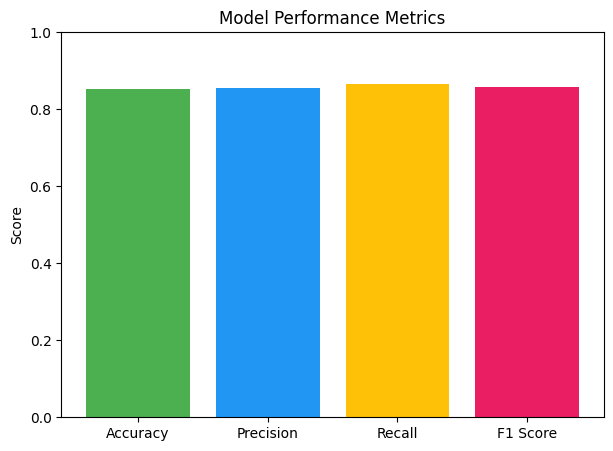

In [32]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc_1, precision_1, recall_1, f1_1]

plt.figure(figsize=(7,5))
plt.bar(metrics, values, color=["#4CAF50", "#2196F3", "#FFC107", "#E91E63"])
plt.ylim(0, 1)  # scores are between 0 and 1
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()

#### **f. Confusion Matrix**

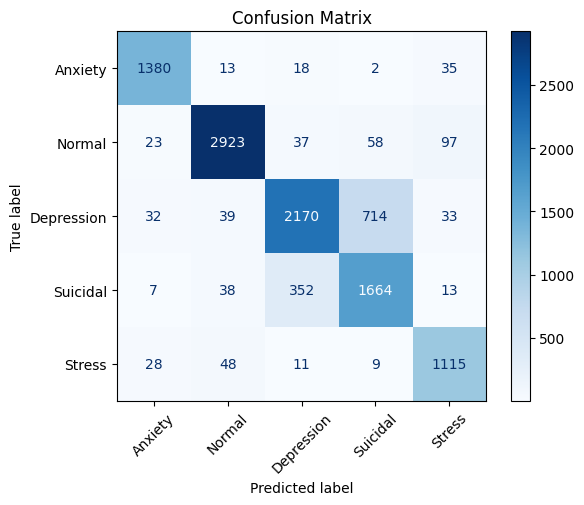

In [33]:
# Sort display labels by their id so order matches your encoded labels
display_labels = [id_to_label[i] for i in range(len(id_to_label))]

disp = ConfusionMatrixDisplay.from_predictions(all_labels_1, all_preds_1, cmap="Blues", xticks_rotation=45, display_labels=display_labels)
plt.title("Confusion Matrix")
plt.show()

#### **g. Confusion Matrix (Percentage)**

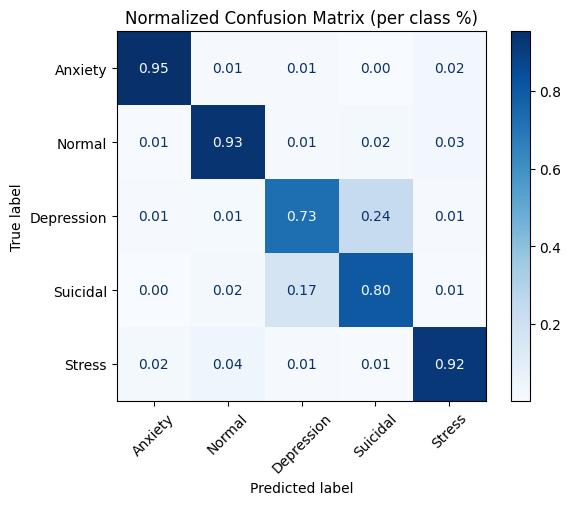

In [34]:
# Compute confusion matrix
cm = confusion_matrix(all_labels_1, all_preds_1, normalize="true")  # normalize rows (true labels)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="Blues", xticks_rotation=45, values_format=".2f")  # 2 decimal places
plt.title("Normalized Confusion Matrix (per class %)")
plt.show()

In [35]:
preds = trainer.predict(dataset["validation"])
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)


In [26]:
print(dataset["validation"].column_names)


['text', 'labels', 'input_ids', 'attention_mask']


In [61]:
id2label = {v: k for k, v in label_to_id.items()}

val_df = dataset["validation"].to_pandas()

confused = []
for text, true, pred in zip(val_df["text"], y_true, y_pred):
    if (id2label[true] in ["Depression", "Suicidal"]) and (id2label[pred] in ["Depression", "Suicidal"]) and true != pred:
        confused.append({"text": text, "true": id2label[true], "pred": id2label[pred]})

df_confused = pd.DataFrame(confused)
df_confused.to_csv("confused_cases.csv", index=False)